In [4]:
# Add the current directory (or folder with your .py files) to the Python path
import sys
import os
sys.path.insert(0, os.getcwd())

# Import necessary libraries
import os
import glob
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import pickle

# Import our custom modules (ensure fmri_dataset.py and model.py are in your working directory)
from fmri_dataset import rfMRIDataset    # see :contentReference[oaicite:0]{index=0}
from model import TimeSeriesTransformer, PositionalEncoder  # see :contentReference[oaicite:1]{index=1}

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Global parameters
data_dir = '/Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1'  # adjust to your data directory
window_size = 30             # number of input timepoints per sample (encoder window)
max_window_size = 50         # maximum window size used in dataset indexing
input_size = 379             # number of regions in each fMRI timepoint
num_predicted_features = 379 # output dimensions, same as input
batch_first = True

# Model hyperparameters
dim_val = 760                # dimension for transformer (should be divisible by n_heads)
n_heads = 8
n_encoder_layers = 4
n_decoder_layers = 4
dec_seq_len = 1              # decoder input length (single time point)
output_sequence_length = 1

# Training parameters
epochs = 10
lr = 1e-4
batch_size = 512

print("Setup complete. Device:", device)


Setup complete. Device: cpu


In [8]:
import os
import glob
import pickle
from torch.utils.data import DataLoader
from fmri_dataset import rfMRIDataset  # Ensure fmri_dataset.py is in your working directory

# Ensure data_dir ends with a trailing slash
data_dir = '/Users/dharanireddy/Downloads/Project_BSP/HCP_S1200_GroupAvg_v1/'
all_items = sorted(os.listdir(data_dir))
print("Contents of data_dir:", all_items)

# Create a dummy subject folder with a dummy .npy file if none exist.
dummy_sub = "dummy_subject"
dummy_sub_dir = os.path.join(data_dir, dummy_sub)

if not os.path.exists(dummy_sub_dir):
    os.makedirs(dummy_sub_dir)
    print(f"Created dummy subject folder: {dummy_sub_dir}")

# Create a dummy file following the expected naming pattern: *REST*_p.npy
dummy_file = os.path.join(dummy_sub_dir, "dummy_REST_p.npy")
if not os.path.exists(dummy_file):
    # Create dummy fMRI time-series data with shape (1200, 379)
    dummy_data = np.random.randn(1200, 379)
    np.save(dummy_file, dummy_data)
    print(f"Created dummy .npy file: {dummy_file}")

# Manually define train and test subjects
train_sub = [dummy_sub]
test_sub  = [dummy_sub]

print("Train subjects:", train_sub)
print("Test subjects:", test_sub)

# Create dataset objects using the custom rfMRIDataset.
# Note: rfMRIDataset searches for files matching '*REST*_p.npy' in each subject folder.
train_dataset = rfMRIDataset(data_dir, train_sub, window_size, max_window_size)
test_dataset  = rfMRIDataset(data_dir, test_sub, window_size, max_window_size)

print("Number of samples in train_dataset:", len(train_dataset))
print("Number of samples in test_dataset:", len(test_dataset))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)

print("DataLoaders created successfully.")


Contents of data_dir: ['.DS_Store', 'ConnectomeWorkbenchTutorial_HCP_S1200_GroupAvg_v1.pdf', 'Gordon333.32k_fs_LR.dlabel.nii', 'Gordon333_Key.txt', 'HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s2_MSMAll.dscalar.nii', 'HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s2_MSMSulc.dscalar.nii', 'HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s4_MSMAll.dscalar.nii', 'HCP_S1200_997_tfMRI_ALLTASKS_level2_cohensd_hp200_s4_MSMSulc.dscalar.nii', 'HCP_S1200_GroupAvg_v1.scene', 'Human.Brodmann09.32k_fs_LR.dlabel.nii', 'Human.Composite_VDG11.32k_fs_LR.dlabel.nii', 'Human.MedialWall_Conte69.32k_fs_LR.dlabel.nii', 'Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii', 'Q1-Q6_RelatedValidation210.L.CorticalAreas_dil_Final_Final_Areas_Group.32k_fs_LR.border', 'Q1-Q6_RelatedValidation210.R.CorticalAreas_dil_Final_Final_Areas_Group.32k_fs_LR.border', 'RSN-networks.32k_fs_LR.dlabel.nii', 'ReleaseNotes_HCP_S1200_GroupAvg_v1.txt', 'S1200.All.MyelinMap_B

Starting training...


Validation: 100%|██████████| 1150/1150 [00:23<00:00, 49.85it/s]


Epoch 1 complete! Training Loss: 1.223732, Validation Loss: 1.040939


Validation: 100%|██████████| 1150/1150 [00:21<00:00, 52.57it/s]


Epoch 2 complete! Training Loss: 1.057577, Validation Loss: 1.014659


Validation: 100%|██████████| 1150/1150 [00:21<00:00, 52.80it/s]


Epoch 3 complete! Training Loss: 1.040284, Validation Loss: 1.010352


Validation: 100%|██████████| 1150/1150 [00:22<00:00, 51.51it/s]


Epoch 4 complete! Training Loss: 1.037427, Validation Loss: 1.007122


Validation: 100%|██████████| 1150/1150 [00:25<00:00, 44.59it/s]


Epoch 5 complete! Training Loss: 1.036315, Validation Loss: 1.004605


Validation: 100%|██████████| 1150/1150 [00:25<00:00, 45.07it/s]


Epoch 6 complete! Training Loss: 1.031264, Validation Loss: 1.003052


Validation: 100%|██████████| 1150/1150 [00:22<00:00, 51.84it/s]


Epoch 7 complete! Training Loss: 1.027171, Validation Loss: 1.002161


Validation: 100%|██████████| 1150/1150 [00:25<00:00, 45.03it/s]


Epoch 8 complete! Training Loss: 1.027783, Validation Loss: 1.001766


Validation: 100%|██████████| 1150/1150 [00:23<00:00, 48.66it/s]


Epoch 9 complete! Training Loss: 1.025328, Validation Loss: 1.001734


Validation: 100%|██████████| 1150/1150 [00:24<00:00, 47.57it/s]


Epoch 10 complete! Training Loss: 1.023273, Validation Loss: 1.000775


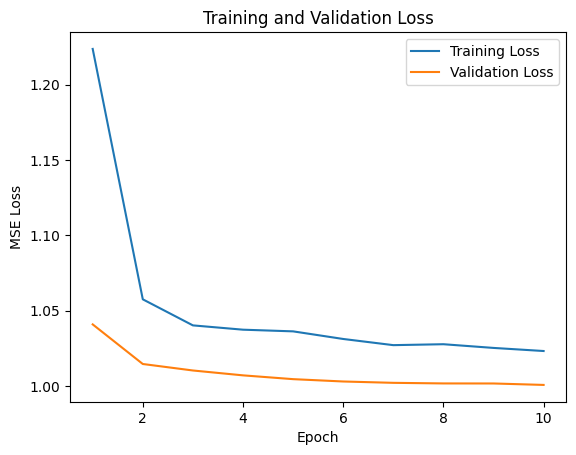

In [9]:
# Import necessary libraries (if not already imported)
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# Import the transformer model
from model import TimeSeriesTransformer, PositionalEncoder  # Ensure model.py is in your working directory

# Global hyperparameters (adjust if needed)
input_size = 379             # number of regions per timepoint
num_predicted_features = 379 # same as input
batch_first = True
dim_val = 760                # transformer model dimension (must be divisible by n_heads)
n_heads = 8
n_encoder_layers = 4
n_decoder_layers = 4
dec_seq_len = 1              # length of decoder input (single time point)
output_sequence_length = 1   # predicting one future timepoint

# Training parameters
epochs = 10
lr = 1e-4
# 'batch_size' is already defined in cell 1

# Initialize the transformer model
model = TimeSeriesTransformer(
    dim_val=dim_val,
    input_size=input_size,
    n_heads=n_heads,
    dec_seq_len=dec_seq_len,
    max_seq_len=window_size,   # Using window_size as the maximum sequence length for positional encoding
    out_seq_len=output_sequence_length,
    n_decoder_layers=n_decoder_layers,
    n_encoder_layers=n_encoder_layers,
    batch_first=batch_first,
    num_predicted_features=num_predicted_features
)

model.to(device)
model = model.double()  # Using double precision as in your code

# Define loss function and optimizer
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Lists to store loss history
train_loss_hist = []
val_loss_hist = []

print("Starting training...")
for epoch in range(epochs):
    model.train()
    epoch_losses = []
    # Training loop over the training DataLoader
    for data, target in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        encoder_input = data.to(device).to(torch.float64)
        # Prepare decoder input as the last timepoint of the sequence
        decoder_input = data[:, -1, :].unsqueeze(1).to(device).to(torch.float64)
        target = target.unsqueeze(1).to(device).to(torch.float64)
        
        # Forward pass
        pred = model(encoder_input, decoder_input)
        loss = loss_func(pred, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
    
    avg_train_loss = np.mean(epoch_losses)
    train_loss_hist.append(avg_train_loss)
    
    # Validation on test_loader
    model.eval()
    val_losses = []
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Validation"):
            encoder_input = data.to(device).to(torch.float64)
            decoder_input = data[:, -1, :].unsqueeze(1).to(device).to(torch.float64)
            target = target.unsqueeze(1).to(device).to(torch.float64)
            pred = model(encoder_input, decoder_input)
            loss_val = loss_func(pred, target)
            val_losses.append(loss_val.item())
    avg_val_loss = np.mean(val_losses)
    val_loss_hist.append(avg_val_loss)
    
    print(f"Epoch {epoch+1} complete! Training Loss: {avg_train_loss:.6f}, Validation Loss: {avg_val_loss:.6f}")

# Save the trained model and loss history
torch.save(model, f'transformer_fold_1_epo-{epochs}_win-{window_size}.pth')
np.save(f'transformer_train_loss_fold_1_epo-{epochs}_win-{window_size}.npy', np.array(train_loss_hist))
np.save(f'transformer_valid_loss_fold_1_epo-{epochs}_win-{window_size}.npy', np.array(val_loss_hist))

# Plot the loss curves
plt.figure()
plt.plot(range(1, epochs+1), train_loss_hist, label="Training Loss")
plt.plot(range(1, epochs+1), val_loss_hist, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


In [10]:
# Ensure model is in evaluation mode
model.eval()

def mse_calc(x, x_hat):
    return nn.functional.mse_loss(x_hat, x)

test_mse_list = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc="Testing single time point"):
        encoder_input = data.to(device).to(torch.float64)
        decoder_input = data[:, -1, :].unsqueeze(1).to(device).to(torch.float64)
        target = target.unsqueeze(1).to(device).to(torch.float64)
        
        pred = model(encoder_input, decoder_input)
        loss = mse_calc(target, pred)
        test_mse_list.append(loss.item())

test_mse_array = np.array(test_mse_list)
print("Test MSE shape:", test_mse_array.shape)
print("Average Test MSE:", test_mse_array.mean())

# Save the test results
np.save('test_results_single_timepoint.npy', test_mse_array)


Testing single time point: 100%|██████████| 1150/1150 [00:20<00:00, 55.59it/s]

Test MSE shape: (1150,)
Average Test MSE: 1.0007754622337526


In [11]:
def mse_calc(x, x_hat):
    return nn.functional.mse_loss(x_hat, x)

# Gather file paths for test subjects (using our dummy subject)
import glob
files = []
for sub in test_sub:
    sub_files = glob.glob(os.path.join(data_dir, sub, '*REST*_p.npy'))
    sub_files.sort()
    files += sub_files

all_session_pred = []
all_session_mse = []

print("Starting full series prediction...")
with torch.no_grad():
    for f in tqdm(files, desc="Predicting entire series"):
        f_data = np.load(f)
        # Start with the first max_window_size timepoints
        data_for_test = f_data[0:max_window_size, :].copy()
        ses_mse = []
        i = max_window_size
        while i < f_data.shape[0]:
            # Prepare input using the last window_size timepoints
            window_data = data_for_test[i-window_size:i, :]
            window_tensor = torch.tensor(window_data).unsqueeze(0).to(device).to(torch.float64)
            decoder_input = window_tensor[:, -1, :].unsqueeze(1).to(device).to(torch.float64)
            
            # Predict the next timepoint
            pred = model(window_tensor, decoder_input)
            pred = pred.squeeze().detach().cpu().numpy()
            
            # Compute error with the true next timepoint
            target = f_data[i, :]
            target_tensor = torch.tensor(target).unsqueeze(0).to(device).to(torch.float64)
            error = mse_calc(target_tensor.unsqueeze(1), torch.tensor(pred).unsqueeze(0).unsqueeze(0).to(device).to(torch.float64))
            ses_mse.append(error.item())
            
            # Append the predicted timepoint to the series
            data_for_test = np.concatenate((data_for_test, pred.reshape(1, -1)), axis=0)
            i += 1
        
        all_session_pred.append(data_for_test)
        all_session_mse.append(ses_mse)

all_session_pred = np.array(all_session_pred)
all_session_mse = np.array(all_session_mse)
print("Predicted series shape:", all_session_pred.shape)
print("MSE series shape:", all_session_mse.shape)

# Save the full series predictions and MSE values
np.save('predicted_fmri_series.npy', all_session_pred)
np.save('test_mse_entire_series.npy', all_session_mse)


Starting full series prediction...


Predicting entire series: 100%|██████████| 1/1 [00:21<00:00, 21.07s/it]

Predicted series shape: (1, 1200, 379)
MSE series shape: (1, 1150)


Predicted next brain state vector shape: (379,)


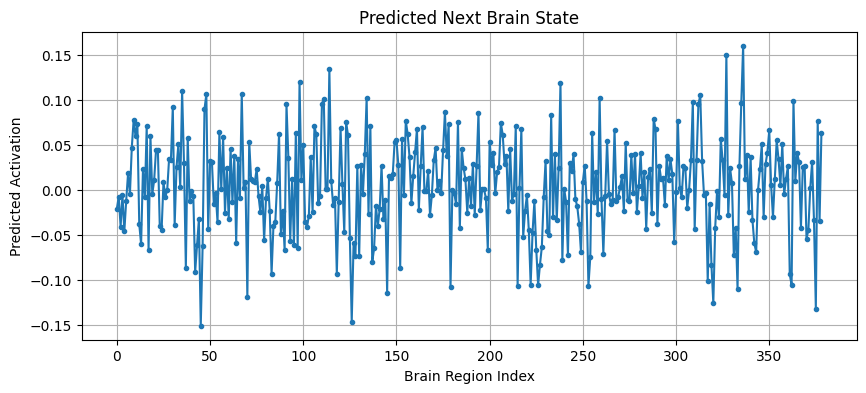

In [12]:
# Cell 6: Predicting the Next Brain State from a Given Input Sequence

# Let's simulate a scenario where you have a recent input sequence of length `window_size`.
# You can use any valid input sequence (shape: [1, window_size, 379]). 
# Here we take the last `window_size` timepoints from our previously predicted series.
input_sequence = all_session_pred[0][-window_size:, :]  # shape: (window_size, 379)
input_sequence = np.expand_dims(input_sequence, axis=0)   # shape: (1, window_size, 379)

# Convert to torch tensor and send to device, ensuring double precision
encoder_input = torch.tensor(input_sequence).to(device).to(torch.float64)

# For the decoder, we use the last timepoint of the input sequence
decoder_input = encoder_input[:, -1, :].unsqueeze(1)

# Ensure the model is in evaluation mode
model.eval()
with torch.no_grad():
    next_state_pred = model(encoder_input, decoder_input)  # shape: (1, 1, 379)

# Extract the predicted brain state vector (1D array of 379 regions)
next_state_pred = next_state_pred.squeeze().cpu().numpy()  # shape: (379,)

print("Predicted next brain state vector shape:", next_state_pred.shape)

# Plot the predicted brain state (activation levels across 379 regions)
plt.figure(figsize=(10, 4))
plt.plot(next_state_pred, marker='o', linestyle='-', markersize=3)
plt.xlabel('Brain Region Index')
plt.ylabel('Predicted Activation')
plt.title('Predicted Next Brain State')
plt.grid(True)
plt.show()
